### **一、causality**
#### 1. 算法简介
&emsp;&emsp;概率因果模型是处理因果关系的一种框架，它使用概率分布来描述变量之间的因果关系。本文使用的causality库实现了潜在遍历啊ing的归纳因果关系(Inductive Causation with latent variables, IC)算法，是一种基于有向图的推断方法，通过观察变量间的条件独立性关系来推断它们之间的因果关系。IC算法通过对原始数据进行条件独立性测试，来构建一个图模型，其中每个节点代表一个变量，有向边代表变量之间的因果关系。算法首先构建一个完全的有向图，然后通过一系列的递归规则逐步减少不必要的边，最终得到一个合理的因果图模型。
#### 2. 使用场景
&emsp;&emsp;本算法适用于对<font color=red>离散型</font>的数据进行因果推断。
#### 3. 算法原理
&emsp;&emsp;算法的核心思想是利用**条件独立性关系**，通过观测数据的统计特征来推断因果关系。它可以处理潜在变量和选择性遗漏等问题，并能够在复杂的因果关系网络中进行推断。具体的流程如下：<br>
(1) 数据准备：离散数据，比如A B C D四个节点，节点A出现为1，未出现为0；<br>
(2) 构建完全图：构建一个有向完全图，其中每个节点都与其他节点存在有向边链接；<br>
(3) 条件独立性测试：对图中的每对变量，进行条件独立性测试判断是否存在因果关系；<br>
(4) 递归：根据条件独立性测试的结果，应用一系列递归规则来逐渐减少图中的边。递归规则包括：递归规则①如果变量A与变量B条件独立，并且变量B与变量C条件独立，则可以推断出变量A与变量C之间不存在直接因果关系，移除A与C之间的边；②如果变量A与变量B条件独立，并且变量C是A与B的共同邻居（即与A和B共同有边连接），则可以推断出变量A与变量B之间存在一个共同的因果关系，在A与B之间添加一个边；<br>
(5) 确定有向边的方向：通过观察变量在递归规则过程中被操作的顺序，确定有向边的方向。如果一个变量在添加了某个边之后，又被移除或替换了多次，那么该边就可以确认方向；<br>
(6) 得到最终的因果图：经过递归规则处理后，得到的图就是最终的因果图，表示变量之间的因果关系。
#### 4. 运行示例
(1) 导入causality相关的包

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest
from IPython.display import Image

(2) 导入相关的数据，定义变量类型（discrete.csv中的数据为离散型数据，因此设置参数为d）

In [8]:
# 读取CSV数据
data = pd.read_csv('../test_data/discrete.csv')

# 定义变量类型（d表示变量均为离散型）
variable_types = {col: 'd' for col in data.columns}

(3) 进行因果推断，并查看因果推断的结果。结果列表中，每个对象为一条边(node1, node2, attribute)，其中attribute['marked']为True表明两个节点之间同时满足真正的因果关系，attribute['arrows']则是说明箭头的指向

In [9]:
# 进行因果推断
ic_algorithm = IC(RobustRegressionTest)
graph = ic_algorithm.search(data, variable_types)

# 打印因果推断的结果
print(graph.edges(data=True))

d:\softwares\pycharm\Anaconda\envs\aiops\lib\site-packages\statsmodels\robust\robust_linear_model.py:290: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)


[('Unnamed: 0', 'a', {'marked': False, 'arrows': ['Unnamed: 0']}), ('Unnamed: 0', 'b', {'marked': False, 'arrows': ['Unnamed: 0']}), ('Unnamed: 0', 'c', {'marked': True, 'arrows': ['c']}), ('Unnamed: 0', 'd', {'marked': False, 'arrows': []}), ('a', 'c', {'marked': False, 'arrows': []}), ('a', 'd', {'marked': True, 'arrows': ['a']}), ('b', 'd', {'marked': False, 'arrows': ['d']}), ('c', 'd', {'marked': False, 'arrows': ['d']})]


(4) 对因果推断的结果进行“剪枝”。去除attribute['marked']为False（即没有满足因果关系）或者attribute['arrows']为空（无向边，干扰图的绘制）的边

In [10]:
# 获取不满足条件的边
edges_to_remove = []
for node1, node2, data in graph.edges(data=True):
    if not (data.get('marked', False) and data.get('arrows', [])):
        edges_to_remove.append((node1, node2))
# 从图中剔除不满足条件的边
graph.remove_edges_from(edges_to_remove)
# 打印剔除边后的结果
print(graph.edges(data=True))

[('Unnamed: 0', 'c', {'marked': True, 'arrows': ['c']}), ('a', 'd', {'marked': True, 'arrows': ['a']})]


(5) 将graph转换成DiGraph，方便可视化因果图。由于转换成DiGraph后，所有边会默认变成双向边，因此对DiGraph进行再次剪枝，去除新增的边

In [11]:
# 使用DiGraph类型
graph = nx.DiGraph(graph)
print(graph.edges(data=True))
# 获取前一半的边
edges_to_keep = list(graph.edges())[:len(graph.edges()) // 2]
# 创建新的有向图，只包含前一半的边
graph = nx.DiGraph(edges_to_keep)
print(graph.edges(data=True))

[('Unnamed: 0', 'c', {'marked': True, 'arrows': ['c']}), ('a', 'd', {'marked': True, 'arrows': ['a']}), ('c', 'Unnamed: 0', {'marked': True, 'arrows': ['c']}), ('d', 'a', {'marked': True, 'arrows': ['a']})]
[('Unnamed: 0', 'c', {}), ('a', 'd', {})]


(6) 寻找剩余边中的根因点，并将根因点设置为红色

In [12]:
# 找到根因点
roots = [node for node in graph.nodes() if graph.in_degree(node) == 0]
non_roots = set(graph.nodes()) - set(roots)
print(roots)

# 将根因点标记为红色
node_colors = ['red' if node in roots else 'lightblue' for node in graph.nodes()]

['Unnamed: 0', 'a']


(7) 对因果推断的结果进行可视化。其中布局算法的选择，如果图较小、节点之间关系简单可以选择circular_layout，如果不知道用哪个布局可以用spring_layout，该布局适用于大多数场景，可以使图尽量保持平衡

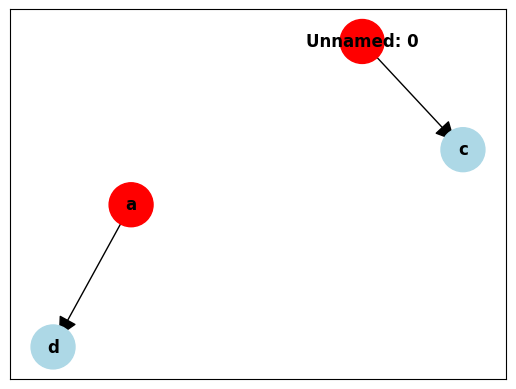

In [14]:
# 获取只包含从根因点出发的边的子图
rooted_subgraph = graph.subgraph(roots + list(non_roots))

# 绘制因果图，仅标注从根因点出发的有向边
pos = nx.spring_layout(rooted_subgraph)  # 选择一个布局算法，这里使用circular_layout
nx.draw_networkx_nodes(rooted_subgraph, pos, node_color=node_colors, node_size=1000)
nx.draw_networkx_edges(rooted_subgraph, pos, edgelist=graph.edges(), arrowsize=30)
nx.draw_networkx_labels(rooted_subgraph, pos, font_weight='bold')
plt.show()

### **二、fp-growth**
#### 1. 算法简介
&emsp;&emsp;频繁模式增长(fp-growth)算法是一种用于挖掘频繁项集的数据挖掘算法。它基于前缀树数据结构（称为FP树），通过利用频繁项的局部性质以及前缀树的压缩技术，能够高效地发现频繁项集。FP-growth算法的主要思想是先构建FP树，然后通过对FP树的遍历和条件模式基的构建，发现频繁项集。
#### 2. 使用场景
&emsp;&emsp;本算法适用于对<font color=red>大规模和高维度</font>的数据进行处理，同事也是一种无监督学习方法，适用于<font color=red>没有标签</font>的情况。
#### 3. 算法原理
&emsp;&emsp;FP-growth算法的优点是它只需对数据集进行两次扫描，因此它比Apriori算法更高效。此外，FP-growth算法使用了压缩技术来减少存储空间的需求，并且可以处理大规模的数据集。过FP-growth算法，我们可以发现频繁项集，即经常一起出现的项的集合。算法的具体步骤如下：<br>
(1) 遍历数据集，统计每个项的支持度，并根据支持度降序排序；<br>
(2) 构建FP树：遍历数据集，对每个事务按照频繁项的支持度降序排序，并将排序后的事务插入FP树中；<br>
(3) 递归地对FP树中的每个节点的条件模式基（由节点的前缀路径构建）进行频繁项集的挖掘；<br>
(4) 根据条件模式基构建条件模式树，再递归地对条件模式树进行挖掘；<br>
(5) 重复步骤3和4，直到没有更多的频繁项集可以挖掘为止。<br>
#### 4. 运行示例
(1) 导入相关的包和模块。由于直接下载fp-growth会导致无法在python3.x的版本上使用，因此直接将修改后的fp_growth_py3源码放到对应的目录进行引用即可

In [66]:
import csv
from fp_growth_py3 import find_frequent_itemsets #目录中的fo_growth_py3.py文件放到代码的目录下导入
import networkx as nx
import matplotlib.pyplot as plt

(2) 导入数据（离散数据），并对数据进行处理，构建初始序列。序列由指标构成，原始数据中有ABCD四个指标，如果A出现了（值为1）则添加到序列中。并对dataset进行过滤，过滤为空（正常）或者仅有一个元素（无根因）的序列

In [68]:
# 读取CSV文件
csv_file_path = '../test_data/discrete.csv'
dataset = []

# 对离散数据进行处理构建序列
with open(csv_file_path, 'r') as file:
    reader = csv.reader(file)
    headers = next(reader)[1:]  # 获取指标的名称列表
    for row in reader:
        indicators = [header for header, value in zip(headers, row[1:]) if value == '1']
        if len(indicators) > 1:
            dataset.append(indicators)
            
# 打印处理后的dataset
print(dataset)

[['c', 'd'], ['a', 'c'], ['c', 'd'], ['b', 'd'], ['b', 'd'], ['c', 'd'], ['b', 'd'], ['a', 'b', 'c'], ['b', 'c'], ['c', 'd'], ['a', 'b', 'c'], ['a', 'b', 'c'], ['a', 'c'], ['b', 'c'], ['b', 'd'], ['a', 'd'], ['a', 'c', 'd'], ['b', 'd'], ['a', 'c', 'd'], ['b', 'c'], ['a', 'b', 'c'], ['b', 'c'], ['b', 'd'], ['b', 'd'], ['a', 'c', 'd'], ['b', 'c'], ['a', 'b', 'c', 'd'], ['b', 'd'], ['c', 'd'], ['a', 'c'], ['a', 'c', 'd'], ['a', 'c', 'd'], ['b', 'c'], ['b', 'd'], ['a', 'c', 'd'], ['c', 'd'], ['b', 'c'], ['c', 'd'], ['a', 'd'], ['c', 'd'], ['b', 'c'], ['a', 'c', 'd'], ['b', 'd'], ['a', 'd'], ['a', 'd'], ['a', 'd'], ['b', 'c'], ['c', 'd'], ['b', 'c', 'd'], ['a', 'b', 'c', 'd'], ['b', 'c'], ['c', 'd'], ['b', 'c'], ['a', 'c', 'd'], ['b', 'c'], ['a', 'c'], ['a', 'd'], ['a', 'b', 'c', 'd'], ['b', 'd'], ['a', 'c'], ['b', 'c'], ['b', 'c'], ['a', 'c', 'd'], ['a', 'c'], ['b', 'd'], ['a', 'c', 'd'], ['a', 'd'], ['b', 'd'], ['a', 'c', 'd'], ['a', 'c', 'd'], ['b', 'd'], ['b', 'c'], ['a', 'c'], ['b', 'c

(3) 定义最小支持度并使用find_frequent_itemsets函数查找频繁项集。这里的min_support是根据用户的使用场景以及数据集的大小进行设置，设置为n则要求频繁集出现的次数大于等于n次，否则将会被过滤

In [71]:
# 定义最小支持度
min_support = 2

# 使用fp-growth包的find_frequent_itemsets函数查找频繁项集
frequent_itemsets = find_frequent_itemsets(dataset, min_support)

(4) 对于查找后的结果进行进一步过滤。查找的结果filter_itemsets并不保留原始数据集中的元素顺序，且对于单个满足min_support的元素也会进行保留（无根因或结果），这将会干扰根因的查找，因此将频繁项集中的元素根据原始顺序进行排序且仅保留包含两个及以上元素的频繁项

In [72]:
# 将频繁项集中的元素根据原始顺序进行排序
headers_index = {item: index for index, item in enumerate(headers)}
def custom_sort(itemset):
    dic = {}
    for item in itemset:
        dic[headers_index[item]] = item
    dic = sorted(dic.items(), key=lambda k:k[0])
    sorted_itemset = []
    for item in dic:
        sorted_itemset.append(item[1])
    return sorted_itemset

# 对结果进行进一步处理，仅保留包含两个及以上元素的频繁项，且按顺序
filter_itemsets = []
for itemset in frequent_itemsets:
    if len(itemset)>1:
        itemset = custom_sort(itemset)
        filter_itemsets.append(itemset)
        print(itemset)

['c', 'd']
['a', 'c']
['a', 'b']
['a', 'b', 'c']
['a', 'b', 'd']
['a', 'b', 'c', 'd']
['a', 'd']
['a', 'c', 'd']
['b', 'd']
['b', 'c', 'd']
['b', 'c']


(5) 基于filter_itemsets构建有向图DiGraph。找到根因点，并将结果进行可视化

['a']


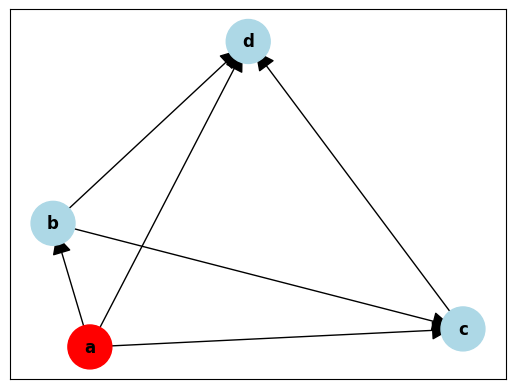

In [73]:
# 构建边集合
edges = []
for itemset in filter_itemsets:
    for i in range(len(itemset) - 1):
        edges.append((itemset[i], itemset[i + 1], {}))

# 构建有向图
graph = nx.DiGraph(edges)

# 找到根因点
roots = [node for node in graph.nodes() if graph.in_degree(node) == 0]
non_roots = set(graph.nodes()) - set(roots)
print(roots)

# 将根因点标记为红色
node_colors = ['red' if node in roots else 'lightblue' for node in graph.nodes()]

# 获取只包含从根因点出发的边的子图
rooted_subgraph = graph.subgraph(roots + list(non_roots))

# 绘制因果图，仅标注从根因点出发的有向边
pos = nx.spring_layout(rooted_subgraph)  # 选择一个布局算法，这里使用circular_layout
nx.draw_networkx_nodes(rooted_subgraph, pos, node_color=node_colors, node_size=1000)
nx.draw_networkx_edges(rooted_subgraph, pos, edgelist=graph.edges(), arrowsize=30)
nx.draw_networkx_labels(rooted_subgraph, pos, font_weight='bold')
plt.show()

### **三、alarm_center**
#### 1. 算法简介
&emsp;&emsp;项目中用于根因定位的主要算法是PageRank算法。PageRank算法是一种用于评估网页重要性的算法，在根因定位中被应用于评估告警事件的重要性。该算法通过迭代计算，给每个节点（即告警事件）一个重要性分数，该分数表示节点在整个网络中的重要性程度。算法的核心思想是，一个节点的重要性取决于指向它的节点的数量和这些节点的重要性。在根因定位中，PageRank算法可以帮助识别与其他事件有较多关联和依赖的事件，从而定位可能的根因。
#### 2. 使用场景
&emsp;&emsp;本项目的方法适用于未经过任何预处理的<font color=red>真实的蓝鲸数据</font>，但是处理所需要的时间较长。
#### 3. 算法原理
该方法的具体步骤如下：<br>
(1) **数据预处理**：读取原始数据文件，进行数据清洗操作，如删除缺失值、处理异常数据等；<br>
(2) **构建关联矩阵**：根据分段后的数据，通过计算告警事件之间的条件概率，构建关联矩阵。关联矩阵的每个元素表示告警事件之间的关联度；<br>
(3) **根因定位**：根据关联矩阵，构建有向图。根据PageRank算法，计算每个告警事件的重要性指标，该指标表示事件在整个网络中的重要性程度。较高的重要性指标意味着告警事件更有可能是根因；<br>
(4) **可视化结果**：根据根因定位的结果，生成拓扑图，并根据告警事件的重要性指标将根因标记出来。拓扑图可以展示告警事件之间的关联关系和根因的位置。<br>
#### 4. 运行示例
&emsp;&emsp;alarm_center相关的实现代码均封装在了alarm_center.py文件中，使用该算法进行根因定位只需导入该py文件调用相关函数即可，运行实例如下：

In [ ]:
import alarm_center as AC
import csv

# 文件处理：将csv文件转为list对象返回（这里进行模拟，真实场景直接传入前端传进来的list对象）
def process_csv(file_path, encoding):
    result_list = []
    with open(file_path, 'r', encoding=encoding) as csv_file:
        # 使用csv.DictReader读取CSV文件，并自动将每行转换为字典
        csv_reader = csv.DictReader(csv_file)

        for row in csv_reader:
            result_list.append(row)
    return result_list
# csv转列表（接入后端后直接传入列表即可，这步无需做）
file_path = '../test_data/alarm_center/original_data_20210909.csv'
data = process_csv(file_path, 'GB18030')

# 用户自定义词典文件路径和拓扑图保存路径
segword_path = '../test_data/alarm_center/segword.txt'
pic_path = '../pictures/'
# 输入data，输出相关结果
result, train_result, each_community_node, G, colors = AC.root_cause_analysis(data, segword_path)
#  对每个社区绘制拓扑图，并将根因标红
AC.showroot(pic_path)